### 📦 第 0 格：导入必要的库
导入了如 `torch`, `cv2`, `numpy`, `matplotlib`, `tqdm`, `torchvision.transforms` 等用于图像处理、模型构建、训练可视化所需的基础包。

In [10]:
import os  # 导入库
import cv2  # 导入库
import torch  # 导入库
import random  # 导入库
import numpy as np  # 导入库
import matplotlib.pyplot as plt  # 导入库
from tqdm import tqdm
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### ⚙️ 第 1 格：超参数配置
定义模型名称、训练轮数、批大小、学习率、测试集比例等训练配置参数。

In [11]:
# 超参数设置
config = {  # 设置模型训练的超参数
    "model_name": "resnet",  # 可选 "resnet" 或 "vgg"
    "num_epochs": 15,
    "batch_size": 32,
    "learning_rate": 0.001,
    "test_size": 0.2,
    "sample_ratio": 1.0
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "Aerial_Landscapes/"

### 🧠 第 2 格：模型初始化函数
根据传入的模型名（resnet 或 vgg）初始化预训练模型并替换输出层以匹配数据集类别数。

In [12]:
def initialize_model(model_name, num_classes, use_pretrained=True):
    input_size = 224
    if model_name == "resnet":
        model = models.resnet18(pretrained=use_pretrained)  # 初始化 ResNet 模型
        model.fc = nn.Linear(model.fc.in_features, num_classes)  # 使用ResNet18
    elif model_name == "vgg":
        model = models.vgg16(pretrained=use_pretrained)  # 初始化 VGG 模型
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    else:
        raise ValueError("不支持的模型名称，请选择 'resnet' 或 'vgg'")
    return model, input_size

### 🧱 第 3 格：图像预处理流程
定义训练和测试图像所使用的图像增强与归一化操作，包括随机裁剪、缩放、标准化等。

In [13]:
def get_transforms(input_size=224):
    train_transform = transforms.Compose([  # 定义图像预处理管道
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    test_transform = transforms.Compose([  # 定义图像预处理管道
        transforms.ToPILImage(),
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return train_transform, test_transform

### 🗂️ 第 4 格：自定义 PyTorch 数据集类
用于将图像和标签组合为 Dataset 对象，以便后续使用 DataLoader 加载。

In [14]:
class CustomDataset(Dataset):  # 自定义数据集类
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, label

### 🧪 第 5 格：数据加载和划分函数
从指定文件夹加载图像数据，并按设定比例划分为训练集和测试集，同时返回类别标签映射。

In [15]:
def load_and_split_dataset(root_dir, test_size=0.2, sample_ratio=1.0):
    classes = sorted(os.listdir(root_dir))
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    train_images, train_labels = [], []
    test_images, test_labels = [], []

    for cls_name in classes:
        cls_path = os.path.join(root_dir, cls_name)
        img_files = [os.path.join(cls_path, f) for f in os.listdir(cls_path) if f.endswith('.jpg')]
        random.seed(42)
        random.shuffle(img_files)
        n_samples = int(len(img_files) * sample_ratio)
        split = int(n_samples * (1 - test_size))
        imgs = img_files[:n_samples]
        train_imgs = imgs[:split]
        test_imgs = imgs[split:]
        train_images.extend([cv2.imread(p) for p in train_imgs])
        train_labels.extend([class_to_idx[cls_name]] * len(train_imgs))
        test_images.extend([cv2.imread(p) for p in test_imgs])
        test_labels.extend([class_to_idx[cls_name]] * len(test_imgs))

    return (train_images, train_labels), (test_images, test_labels), classes

### 🔁 第 6 格：ResNet/VGG 训练函数
包括训练循环、Early Stopping、loss 和 acc 的记录，并在训练完成后绘制学习曲线图。

In [16]:
from tqdm import tqdm

def train_model(model, device, train_loader, test_loader, criterion, optimizer,  # 定义 ResNet/VGG 通用训练函数
                num_epochs=25, checkpoint_path='checkpoint.pth', patience=5):

    best_acc = 0.0
    epochs_no_improve = 0
    early_stop = False
    history = {
        'train_loss': [], 'train_acc': [],
        'test_loss': [], 'test_acc': []
    }

    for epoch in range(num_epochs):
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
        for batch in train_loader_tqdm:
            if early_stop:
                print(f"⚠️ 早停触发于第 {epoch+1} 轮")
                break

        model.train()
        train_loss, correct_train, total_train = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == labels.data)
            total_train += labels.size(0)

        epoch_train_loss = train_loss / total_train
        epoch_train_acc = correct_train.double() / total_train
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc.item())

        model.eval()
        test_loss, correct_test, total_test = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_test += torch.sum(preds == labels.data)
                total_test += labels.size(0)

        epoch_test_loss = test_loss / total_test
        epoch_test_acc = correct_test.double() / total_test
        history['test_loss'].append(epoch_test_loss)
        history['test_acc'].append(epoch_test_acc.item())

        print(f"Epoch {epoch+1}: Train Acc={epoch_train_acc:.4f}, Test Acc={epoch_test_acc:.4f}")

        if epoch_test_acc > best_acc:
            best_acc = epoch_test_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), checkpoint_path)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                early_stop = True

    return model, history

### 📊 第 7 格：评估函数
对模型在测试集上的表现进行评估，生成预测值与真实值列表，可用于后续可视化。

In [17]:
def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels)
            y_pred.extend(preds.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation='vertical', cmap='Blues')

### 🧪 第 8 格：加载数据集
调用数据加载函数并获取训练图像、测试图像、类别标签等信息。

/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/15: 100%|██████████| 300/300 [00:12<00:00, 23.47batch/s]


Epoch 1: Train Acc=0.6573, Test Acc=0.7358


Epoch 2/15: 100%|██████████| 300/300 [00:12<00:00, 23.53batch/s]


Epoch 2: Train Acc=0.7570, Test Acc=0.7733


Epoch 3/15: 100%|██████████| 300/300 [00:13<00:00, 22.17batch/s]


Epoch 3: Train Acc=0.8011, Test Acc=0.8404


Epoch 4/15: 100%|██████████| 300/300 [00:13<00:00, 22.61batch/s]


Epoch 4: Train Acc=0.8202, Test Acc=0.8579


Epoch 5/15: 100%|██████████| 300/300 [00:39<00:00,  7.51batch/s]


Epoch 5: Train Acc=0.8282, Test Acc=0.8500


Epoch 6/15: 100%|██████████| 300/300 [00:46<00:00,  6.47batch/s]


Epoch 6: Train Acc=0.8421, Test Acc=0.8846


Epoch 7/15: 100%|██████████| 300/300 [00:37<00:00,  7.99batch/s]


Epoch 7: Train Acc=0.8494, Test Acc=0.8958


Epoch 8/15: 100%|██████████| 300/300 [00:31<00:00,  9.59batch/s]


Epoch 8: Train Acc=0.8545, Test Acc=0.9083


Epoch 9/15: 100%|██████████| 300/300 [00:35<00:00,  8.37batch/s]


Epoch 9: Train Acc=0.8727, Test Acc=0.9179


Epoch 10/15: 100%|██████████| 300/300 [00:50<00:00,  5.94batch/s]


Epoch 10: Train Acc=0.8781, Test Acc=0.8633


Epoch 11/15: 100%|██████████| 300/300 [00:36<00:00,  8.27batch/s]


Epoch 11: Train Acc=0.8741, Test Acc=0.8975


Epoch 12/15: 100%|██████████| 300/300 [00:31<00:00,  9.63batch/s]


Epoch 12: Train Acc=0.8731, Test Acc=0.8954


Epoch 13/15: 100%|██████████| 300/300 [00:36<00:00,  8.26batch/s]


Epoch 13: Train Acc=0.8849, Test Acc=0.9271


Epoch 14/15: 100%|██████████| 300/300 [00:46<00:00,  6.47batch/s]


Epoch 14: Train Acc=0.8850, Test Acc=0.9175


Epoch 15/15: 100%|██████████| 300/300 [00:33<00:00,  9.06batch/s]


Epoch 15: Train Acc=0.8870, Test Acc=0.9117
Evaluation Metrics (Precision, Recall, F1-score):

              precision    recall  f1-score   support

 Agriculture     0.8541    0.9875    0.9159       160
     Airport     0.9355    0.7250    0.8169       160
       Beach     0.9929    0.8750    0.9302       160
        City     0.9538    0.7750    0.8552       160
      Desert     0.9345    0.9812    0.9573       160
      Forest     0.9677    0.9375    0.9524       160
   Grassland     0.9677    0.9375    0.9524       160
     Highway     0.8539    0.9500    0.8994       160
        Lake     0.9162    0.9563    0.9358       160
    Mountain     0.9102    0.9500    0.9297       160
     Parking     0.8587    0.9875    0.9186       160
        Port     0.9868    0.9375    0.9615       160
     Railway     0.8608    0.8500    0.8553       160
 Residential     0.8466    1.0000    0.9169       160
       River     0.8980    0.8250    0.8599       160

    accuracy                         0.

<Figure size 1200x1000 with 0 Axes>

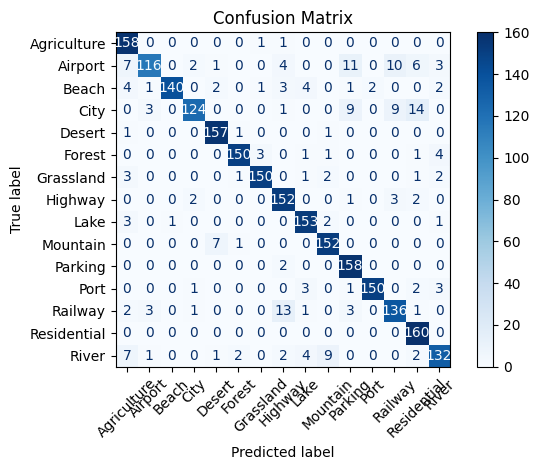

In [18]:
(train_images, train_labels), (test_images, test_labels), classes = load_and_split_dataset(
    dataset_path,
    test_size=config["test_size"],  # 设置模型训练的超参数
    sample_ratio=config["sample_ratio"]  # 设置模型训练的超参数
)

model, input_size = initialize_model(
    model_name=config["model_name"],  # 设置模型训练的超参数
    num_classes=len(classes),
    use_pretrained=True
)
model = model.to(device)

train_transform, test_transform = get_transforms(input_size)

train_dataset = CustomDataset(train_images, train_labels, train_transform)
test_dataset = CustomDataset(test_images, test_labels, test_transform)
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)  # 设置模型训练的超参数
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)  # 设置模型训练的超参数

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])  # 设置模型训练的超参数

model, history = train_model(
    model, device, train_loader, test_loader,
    criterion, optimizer,
    num_epochs=config["num_epochs"],  # 设置模型训练的超参数
    patience=5
)

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels)
        y_pred.extend(preds.cpu().numpy())

report = classification_report(y_true, y_pred, target_names=classes, digits=4)
print("Evaluation Metrics (Precision, Recall, F1-score):\n")
print(report)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
plt.figure(figsize=(12, 10))
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

### ▶️ 第 9 格：run_and_evaluate 函数
这是一个便捷函数，用于初始化模型、训练并评估结果，适用于快速比较多个模型表现。

In [19]:
def run_and_evaluate(model_name, classes):  # 执行模型训练和评估
    (train_images, train_labels), (test_images, test_labels), _ = load_and_split_dataset(
        dataset_path,
        test_size=config["test_size"],  # 设置模型训练的超参数
        sample_ratio=config["sample_ratio"]  # 设置模型训练的超参数
    )

    model, input_size = initialize_model(
        model_name=model_name,
        num_classes=len(classes),
        use_pretrained=True
    )
    model = model.to(device)

    train_transform, test_transform = get_transforms(input_size)

    train_dataset = CustomDataset(train_images, train_labels, train_transform)
    test_dataset = CustomDataset(test_images, test_labels, test_transform)
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)  # 设置模型训练的超参数
    test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)  # 设置模型训练的超参数

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])  # 设置模型训练的超参数

    model, _ = train_model(
        model, device, train_loader, test_loader,
        criterion, optimizer,
        num_epochs=config["num_epochs"],  # 设置模型训练的超参数
        patience=5
    )

    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels)
            y_pred.extend(preds.cpu().numpy())

    report = classification_report(y_true, y_pred, target_names=classes, digits=4)
    print(f"===== {model_name.upper()} Evaluation Metrics =====\n")
    print(report)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    plt.figure(figsize=(12, 10))
    disp.plot(xticks_rotation=45, cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name.upper()}")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

🔍 正在比较 ResNet16 与 VGG16 的分类性能...



/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/15: 100%|██████████| 300/300 [00:31<00:00,  9.49batch/s]


Epoch 1: Train Acc=0.6622, Test Acc=0.7517


Epoch 2/15: 100%|██████████| 300/300 [00:31<00:00,  9.48batch/s]


Epoch 2: Train Acc=0.7669, Test Acc=0.7942


Epoch 3/15: 100%|██████████| 300/300 [00:47<00:00,  6.38batch/s]


Epoch 3: Train Acc=0.7998, Test Acc=0.8567


Epoch 4/15: 100%|██████████| 300/300 [00:36<00:00,  8.21batch/s]


Epoch 4: Train Acc=0.8146, Test Acc=0.8175


Epoch 5/15: 100%|██████████| 300/300 [00:30<00:00,  9.89batch/s]


Epoch 5: Train Acc=0.8315, Test Acc=0.8988


Epoch 6/15: 100%|██████████| 300/300 [00:36<00:00,  8.14batch/s]


Epoch 6: Train Acc=0.8432, Test Acc=0.9000


Epoch 7/15: 100%|██████████| 300/300 [00:46<00:00,  6.45batch/s]


Epoch 7: Train Acc=0.8507, Test Acc=0.8908


Epoch 8/15: 100%|██████████| 300/300 [00:30<00:00,  9.70batch/s]


Epoch 8: Train Acc=0.8588, Test Acc=0.9150


Epoch 9/15: 100%|██████████| 300/300 [00:31<00:00,  9.64batch/s]


Epoch 9: Train Acc=0.8632, Test Acc=0.8779


Epoch 10/15: 100%|██████████| 300/300 [00:45<00:00,  6.58batch/s]


Epoch 10: Train Acc=0.8688, Test Acc=0.8863


Epoch 11/15: 100%|██████████| 300/300 [00:37<00:00,  8.04batch/s]


Epoch 11: Train Acc=0.8771, Test Acc=0.9275


Epoch 12/15: 100%|██████████| 300/300 [00:12<00:00, 23.61batch/s]


Epoch 12: Train Acc=0.8796, Test Acc=0.8842


Epoch 13/15: 100%|██████████| 300/300 [00:13<00:00, 22.87batch/s]


Epoch 13: Train Acc=0.8768, Test Acc=0.9108


Epoch 14/15: 100%|██████████| 300/300 [00:13<00:00, 23.01batch/s]


Epoch 14: Train Acc=0.8896, Test Acc=0.9096


Epoch 15/15: 100%|██████████| 300/300 [00:12<00:00, 23.65batch/s]


Epoch 15: Train Acc=0.8865, Test Acc=0.9221
===== RESNET Evaluation Metrics =====

              precision    recall  f1-score   support

 Agriculture     0.9264    0.9437    0.9350       160
     Airport     0.8462    0.8938    0.8693       160
       Beach     0.9613    0.9313    0.9460       160
        City     0.9853    0.8375    0.9054       160
      Desert     0.9423    0.9187    0.9304       160
      Forest     0.8870    0.9812    0.9318       160
   Grassland     0.9608    0.9187    0.9393       160
     Highway     0.9412    0.9000    0.9201       160
        Lake     0.8596    0.9563    0.9053       160
    Mountain     0.9030    0.9313    0.9169       160
     Parking     0.9747    0.9625    0.9686       160
        Port     0.9935    0.9500    0.9712       160
     Railway     0.8690    0.9125    0.8902       160
 Residential     0.9167    0.9625    0.9390       160
       River     0.8986    0.8313    0.8636       160

    accuracy                         0.9221      24

<Figure size 1200x1000 with 0 Axes>

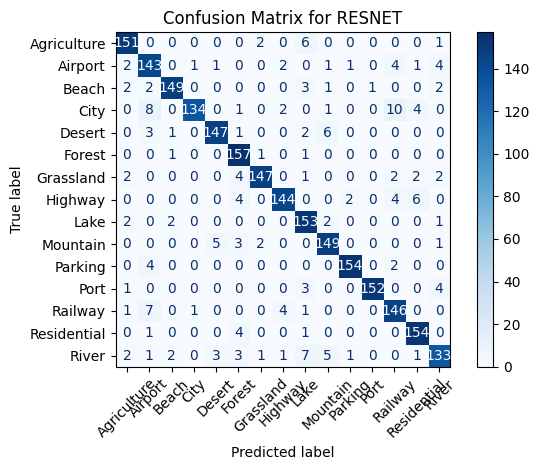

In [20]:
print("🔍 正在比较 ResNet18 与 VGG16 的分类性能...\n")
run_and_evaluate("resnet", classes)  # 执行模型训练和评估

In [24]:
def train_vgg_model(model, device, train_loader, val_loader, criterion, optimizer, num_epochs=10):  # 定义 VGG 的独立训练函数
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):  # 加 tqdm 显示训练进度
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        train_losses.append(running_loss / len(train_loader))
        train_accs.append(correct / total)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_correct / val_total)

        print(f"[VGG] Epoch {epoch+1}/{num_epochs} - Train Acc: {train_accs[-1]:.4f} - Val Acc: {val_accs[-1]:.4f}")

    import matplotlib.pyplot as plt  # 导入库
    import numpy as np  # 导入库
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss", c="red")
    plt.plot(val_losses, label="Val Loss", c="blue")
    plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend(); plt.show()
    plt.figure(figsize=(10, 5))
    plt.plot(train_accs, label="Train Acc", c="orangered")
    plt.plot(val_accs, label="Val Acc", c="green")
    plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend(); plt.show()

/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15: 100%|██████████| 300/300 [00:41<00:00,  7.19it/s]


[VGG] Epoch 1/15 - Train Acc: 0.1925 - Val Acc: 0.1938


Epoch 2/15: 100%|██████████| 300/300 [00:41<00:00,  7.23it/s]


[VGG] Epoch 2/15 - Train Acc: 0.3167 - Val Acc: 0.2462


Epoch 3/15: 100%|██████████| 300/300 [00:41<00:00,  7.24it/s]


[VGG] Epoch 3/15 - Train Acc: 0.3779 - Val Acc: 0.3721


Epoch 4/15: 100%|██████████| 300/300 [00:42<00:00,  7.12it/s]


[VGG] Epoch 4/15 - Train Acc: 0.4161 - Val Acc: 0.3954


Epoch 5/15: 100%|██████████| 300/300 [00:41<00:00,  7.20it/s]


[VGG] Epoch 5/15 - Train Acc: 0.4350 - Val Acc: 0.4462


Epoch 6/15: 100%|██████████| 300/300 [00:41<00:00,  7.20it/s]


[VGG] Epoch 6/15 - Train Acc: 0.4707 - Val Acc: 0.4800


Epoch 7/15: 100%|██████████| 300/300 [00:41<00:00,  7.28it/s]


[VGG] Epoch 7/15 - Train Acc: 0.4816 - Val Acc: 0.5212


Epoch 8/15: 100%|██████████| 300/300 [00:42<00:00,  7.12it/s]


[VGG] Epoch 8/15 - Train Acc: 0.4921 - Val Acc: 0.5029


Epoch 9/15: 100%|██████████| 300/300 [00:41<00:00,  7.26it/s]


[VGG] Epoch 9/15 - Train Acc: 0.4820 - Val Acc: 0.5146


Epoch 10/15: 100%|██████████| 300/300 [00:41<00:00,  7.27it/s]


[VGG] Epoch 10/15 - Train Acc: 0.5039 - Val Acc: 0.4879


Epoch 11/15: 100%|██████████| 300/300 [00:41<00:00,  7.16it/s]


[VGG] Epoch 11/15 - Train Acc: 0.5195 - Val Acc: 0.5308


Epoch 12/15: 100%|██████████| 300/300 [00:42<00:00,  7.04it/s]


[VGG] Epoch 12/15 - Train Acc: 0.5290 - Val Acc: 0.5363


Epoch 13/15: 100%|██████████| 300/300 [00:41<00:00,  7.17it/s]


[VGG] Epoch 13/15 - Train Acc: 0.5354 - Val Acc: 0.5625


Epoch 14/15: 100%|██████████| 300/300 [00:42<00:00,  7.10it/s]


[VGG] Epoch 14/15 - Train Acc: 0.5513 - Val Acc: 0.5842


Epoch 15/15: 100%|██████████| 300/300 [00:41<00:00,  7.18it/s]


[VGG] Epoch 15/15 - Train Acc: 0.5690 - Val Acc: 0.5667


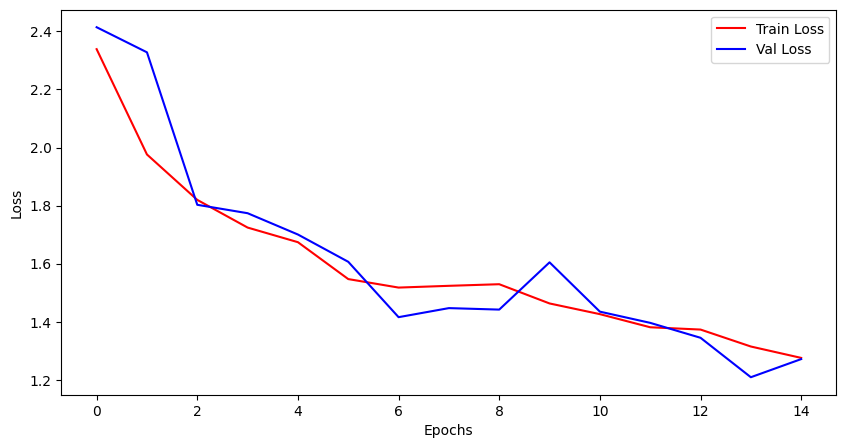

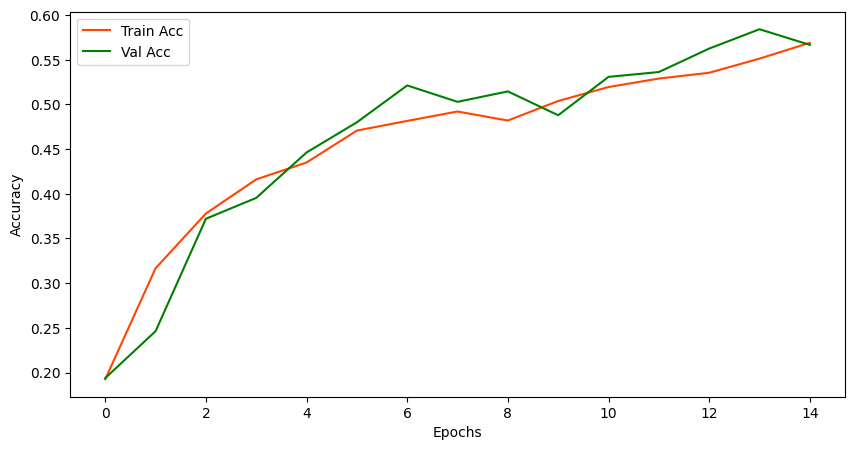

In [27]:
vgg_model = initialize_model("vgg", num_classes=len(classes))[0].to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg_model.parameters(), lr=config["learning_rate"])  # 设置模型训练的超参数

train_vgg_model(vgg_model, device, train_loader, test_loader, criterion, optimizer, num_epochs=config["num_epochs"]) # 设置模型训练的超参数


==================== VGG Evaluation Metrics ====================
              precision    recall  f1-score   support

 Agriculture       0.48      0.59      0.53       160
     Airport       0.42      0.19      0.27       160
       Beach       0.81      0.66      0.72       160
        City       0.49      0.60      0.54       160
      Desert       0.92      0.76      0.83       160
      Forest       0.91      0.55      0.68       160
   Grassland       0.57      0.89      0.70       160
     Highway       0.15      0.15      0.15       160
        Lake       0.78      0.76      0.77       160
    Mountain       0.43      0.34      0.38       160
     Parking       0.61      0.93      0.74       160
        Port       0.80      0.81      0.80       160
     Railway       0.42      0.31      0.35       160
 Residential       0.45      0.74      0.56       160
       River       0.35      0.22      0.27       160

    accuracy                           0.57      2400
   macro avg  

NameError: name 'model_name' is not defined

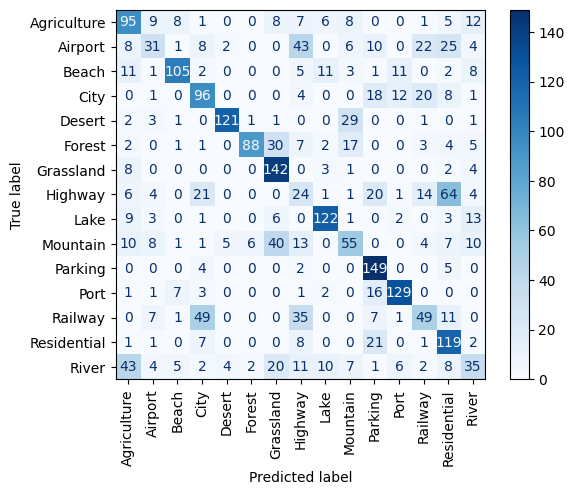

In [30]:
# ✅ 使用 evaluate_model 函数评估 VGG 模型分类表现
print("\n==================== VGG Evaluation Metrics ====================")
evaluate_model(vgg_model, test_loader, device, class_names=classes)
plt.title(f"Confusion Matrix for {model_name.upper()}")

In [ ]:
import os  # 导入库
import cv2  # 导入库
import torch  # 导入库
import numpy as np  # 导入库
import matplotlib.pyplot as plt  # 导入库
from collections import defaultdict
from torchcam.methods import GradCAM

def overlay_heatmap(img: np.ndarray, cam: np.ndarray, alpha: float = 0.5) -> np.ndarray:
    cam_uint8 = np.uint8(255 * cam)
    heatmap = cv2.applyColorMap(cam_uint8, cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    if img.max() > 1.0:
        img = np.float32(img) / 255
    if img.shape[:2] != heatmap.shape[:2]:
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    overlayed = heatmap * alpha + img
    overlayed = overlayed / np.max(overlayed)
    return np.uint8(255 * overlayed)

def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def apply_gradcam_all_classes(model, device, dataloader, model_name="resnet", save_dir="gradcam_outputs"):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()

    if model_name == "resnet":
        target_layer = model.layer4[-1].conv2
    elif model_name == "vgg":
        target_layer = model.features[-1]
    else:
        raise ValueError("Unsupported model")

    cam_extractor = GradCAM(model, target_layer=target_layer)

    seen_classes = defaultdict(int)
    total_target_classes = 15
    class_id_to_name = [
        "Agriculture", "Airport", "Beach", "City", "Desert", "Forest", "Grassland", "Highway",
        "Lake", "Mountain", "Parking", "Port", "Railway", "Residential", "River"
    ]

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)

        for i in range(inputs.shape[0]):
            label = labels[i].item()
            if seen_classes[label] >= 1:
                continue 

            img_tensor = inputs[i].unsqueeze(0)
            output = model(img_tensor)
            class_idx = torch.argmax(output).item()

            cam_tensor = cam_extractor(class_idx=class_idx, scores=output)[0]
            cam = cam_tensor.cpu().numpy()
            if cam.ndim == 3:
                cam = cam[0]
            cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

            unnorm_img_tensor = unnormalize(img_tensor.squeeze(0).cpu(),
                                            mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225])
            raw_image = np.clip(unnorm_img_tensor.permute(1, 2, 0).numpy(), 0, 1)

            cam = cv2.resize(cam, (raw_image.shape[1], raw_image.shape[0]))
            result = overlay_heatmap(raw_image, cam)
            result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

            orig_img = np.uint8(raw_image * 255)
            orig_bgr = cv2.cvtColor(orig_img, cv2.COLOR_RGB2BGR)
            result_bgr = cv2.cvtColor(result_rgb, cv2.COLOR_RGB2BGR)

            cname = class_id_to_name[label]
            cv2.imwrite(os.path.join(save_dir, f"{cname}_original.png"), orig_bgr)
            cv2.imwrite(os.path.join(save_dir, f"{cname}_gradcam.png"), result_bgr)
            cv2.imwrite(os.path.join(save_dir, f"{cname}_compare.png"), np.hstack((orig_bgr, result_bgr)))

            fig, axs = plt.subplots(1, 2, figsize=(10, 4))
            axs[0].imshow(orig_img)
            axs[0].set_title(f"{cname} - Original")
            axs[0].axis('off')
            axs[1].imshow(result_rgb)
            axs[1].set_title(f"{cname} - GradCAM (Pred: {class_id_to_name[class_idx]})")
            axs[1].axis('off')
            plt.tight_layout()
            plt.show()

            seen_classes[label] += 1

        if len(seen_classes) >= total_target_classes:
            print("✅ 已为所有类别生成 Grad-CAM 可视化。")
            break

In [ ]:
apply_gradcam_all_classes(model, device, test_loader, model_name="resnet")